Computer: lintu.ucsd.edu


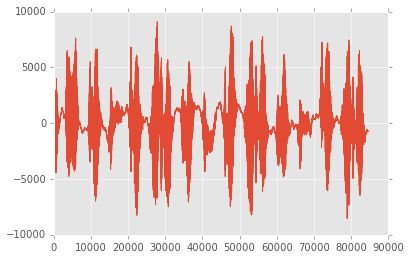

In [4]:
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct

matplotlib.style.use('ggplot')

comp_name=socket.gethostname()
print 'Computer: ' + comp_name
if  comp_name == 'chim':
    sys.path.append('C:\Users\GentnerLab\Documents\Experiment\scripts\sound_tools')
    experiment_folder = os.path.join('C:\Users\GentnerLab\Documents\Experiment')
    r = os.path.join('C:\Users\GentnerLab\Documents\Experiment')
    raw_data_folder = os.path.join(experiment_folder, 'raw_data')

if 'lintu' in comp_name:
    sys.path.append('/mnt/cube/earneodo/repos/soundflow/sound_tools')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')
    raw_data_folder = os.path.join(experiment_folder, 'raw_data')
#test soundtools
from soundtools import WavData, Chunk
    
#file structure
bird_id = 'z003'
sess = 1
rec = 'a'
run = 5
bout = '2251_869'

#load the bout and the whole sound file for searching
raw_file_folder = os.path.join(raw_data_folder, bird_id, str(sess).zfill(3))
raw_file_name = rec + '_' + str(run).zfill(2) + '_song.wav'
raw_file_path = os.path.join(raw_file_folder, raw_file_name)

#the whole sound
all_sound = WavData(raw_file_path)

#the bout
if bout is not None:
    raw_file_folder = os.path.join(raw_file_folder, 'bouts')
    raw_file_name = rec + '_' + str(run).zfill(2) + '_song_' + bout + '.wav'

raw_file_path = os.path.join(raw_file_folder, raw_file_name)
bout_sound = WavData(raw_file_path)

#get a piece, filter it, plot it
window_t = 234700 #time window in msec
window_size = 1000 # window len in msec

window_t_samples = int(round(window_t*bout_sound.s_f/1000.))
window_samples = int(round(window_size*bout_sound.s_f/1000.))
window_samples = min(window_samples, bout_sound.n_samples - window_t_samples)

if bout is not None:
    segment = [0, None]
else:
    segment=[window_t_samples, window_t_samples + window_samples]

window = Chunk(bout_sound, segment=segment)
plt.plot(np.transpose(window.data))
# window2 = window2 = Chunk(sound, segment=segment, chan_list = [0, 1])
# plt.plot(np.transpose(window2.data));

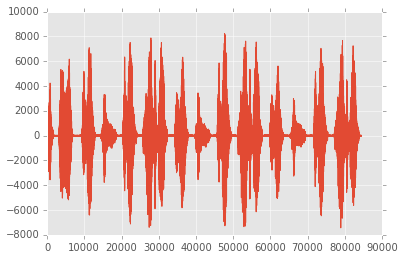

In [78]:
#filter the signal
s_f = window.sound.s_f

filt_lo = 10000 #Hz
filt_hi = 400 #Hz
hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')

def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt
    
window.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)
plt.plot(np.transpose(window.data))

65949.0
312529
11735.0


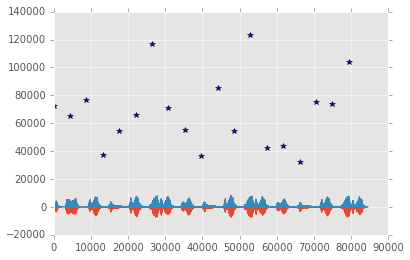

In [77]:
def rms(x):
    return np.linalg.norm(x)

def mad(x):
    med = np.median(x)
    dev = np.abs(x - np.median(x))
    return np.median(dev)

def identity(x):
    return x

bout = Chunk(bout_sound)
size = 100
size_sample = np.int(size*bout_sound.s_f*0.001)
starts = np.arange(0, bout.samples - size_sample, size_sample)

rms_vec_bout = bout_sound.apply_repeated(starts, size_sample, rms_band_pass_filter, hp_b, hp_a, lp_b, lp_a)

bout.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)

#print rms_vec
plt.plot(starts, rms_vec_bout, 'b*')

plt.plot(range(bout.samples), np.transpose(bout.data))
plt.plot(range(bout.samples), np.transpose(np.abs(bout.data)))
#print rms_vec
print np.median(rms_vec_bout)
print np.int(np.median(rms(bout.data)))
print mad(rms_vec_bout)


In [75]:
def rms_after_filter(filter_func):
    def out_of_filtered(*args, **kwargs):
        #print "Arguments were: %s, %s" % (args, kwargs)
        #plt.plot(np.transpose(filter_func(*args, **kwargs)))
        return np.linalg.norm(filter_func(*args, **kwargs))
    return out_of_filtered


window = Chunk(bout_sound)

@rms_after_filter
def rms_band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):
    #plt.plot(np.transpose(chunk))
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

@rms_after_filter
def rms_identity(chunk):
    return(chunk)

print rms_band_pass_filter(window.data, hp_b, hp_a, lp_b, lp_a)
print rms_identity(window.data)
#window.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)
#print window.data

312529.262153
396190.566218


504.0
102.0
606.0


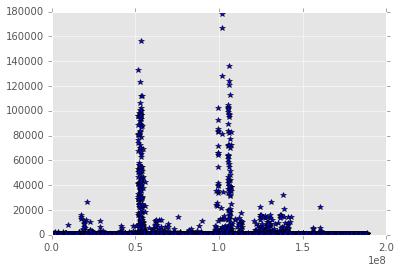

In [76]:
all_starts = np.arange(0, all_sound.n_samples - size_sample, size_sample)
starts = np.random.choice(all_starts, size = np.int(all_starts.size*0.25), replace=False)

rms_vec = np.empty_like(starts)

rms_vec = all_sound.apply_repeated(starts, size_sample, rms_band_pass_filter, hp_b, hp_a, lp_b, lp_a)

#get a segment of 50 starts and plot it
plot_starts = starts[1:30]
#print rms_vec
plt.plot(starts, rms_vec, 'b*')
#plot_bout = Chunk(all_sound, segment=[starts[0], starts[0] + ] )
#plt.plot(range(plot_bout.samples), np.transpose(plot_bout.data))
#plt.plot(range(plot_bout.samples), np.transpose(np.abs(plot_bout.data)))
np.median(rms_vec)

print np.median(rms_vec)
print mad(rms_vec)
print np.median(rms_vec) + mad(rms_vec)

45499.0
14150.0
59649.0


45707.0

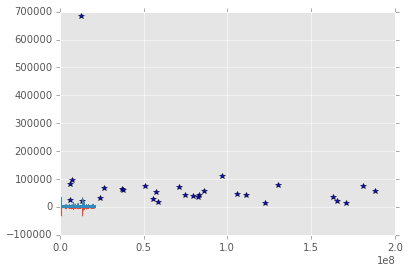

In [63]:
#get a segment of 50 starts and plot it
plot_starts = starts[1:30]
#print rms_vec
plt.plot(plot_starts, rms_vec[1:30], 'b*')
plot_bout = Chunk(all_sound, segment=[starts[0], starts[-1]] )
plt.plot(range(plot_bout.samples), np.transpose(plot_bout.data))
plt.plot(range(plot_bout.samples), np.transpose(np.abs(plot_bout.data)))
np.median(rms_vec)

In [37]:
print all_sound.n_samples/size_sample
print all_starts.size
print starts.size

85485
85485
0


In [13]:
bout = Chunk(all_sound)
size = 10
size_sample = np.int(size*sound.s_f*0.001)

starts = np.arange(0, bout.samples - size_sample, size_sample)
print starts.size

rms_vec = np.empty_like(starts)

427425


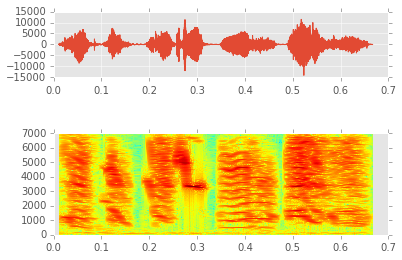

In [12]:
# variables and parameters
y = window.data[0,:]
fs = window.sound.s_f
t = np.arange(0,y.shape[0], dtype=np.float)/fs

n_window = 1024
n_overlap = n_window-1
sigma = 7./1000.*fs

# pad the window so the output is the same size as the input
assert(n_window%2 == 0)
before_padding = n_window/2
after_padding = n_window/2 -1 
x = np.pad(y, (before_padding, after_padding), 'constant', constant_values = (0,0))

# Get the spectrogram of the padded segment
# overlap is n_window - 1, so that it slides across each time point
# window is gaussian so it ends up doing a sliding gabor transform, which is what I need to compute the fundamental
f, t, Sxx = sg.spectrogram(x, fs, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')

ax1 = plt.subplot(311)
plt.plot(t, y)
plt.subplot(212, sharex=ax1)
plt.pcolormesh(t, f, np.log(Sxx))
plt.ylim(0, 7000)

plt.show()

